# Thesis 

In [1]:
import import_ipynb
from Auxillary_functions import *
import ECoG

importing Jupyter notebook from Auxillary_functions.ipynb


### Данные 

Будем рассматривать в качестве выборок несоклько вариантов разбиения данных.
Первый случай: данные об одной обезьяне, снятые в разные дни. Ведь в идеале хочется достичь результата, при котором модель, построенная один раз, работала ,бы для последующих экспериментов.
Второй случай: стандартное разбиение одной выборки на train/test. 

Рассматриваем subdural ECoG for monkey K from 27.05.2009

In [2]:
centers = [(4,1), (6, 1), (8,1),\
           (3, 2), (5, 2), (7,2),\
           (2, 3), (4, 3), (6, 3), (8,3),\
           (1, 4), (3, 4), (5, 4), (7, 4),\
           (2, 5), (4, 5), (6, 5), \
           (1, 6), (3, 6), (5, 6), (7, 6),\
           (2, 7), (4, 7), (6, 7), (8, 7),\
           (1, 8), (3, 8), (5, 8), (7, 8),\
           (2, 9), (4, 9), (6, 9), (8, 9),\
           (1, 10), (3, 10), (5, 10), (7, 10),\
           (2, 11), (4, 11), (6, 11), (8, 11),\
           (1, 12), (3, 12), (5, 12), (7, 12),\
           (2, 13), (4, 13), (6, 13), (8, 13),\
           (1, 14), (3, 14), (5, 14), (7, 14),\
           (2, 15), (4, 15), (6, 15), (8, 15),\
           (1, 16), (3, 16), (5, 16), (7, 16),\
           (2, 17), (4, 17), (6, 17)]

### Raw ECoG 

In [3]:
x,y = ECoG.read_ECoG_from_csv("ECoG.csv","Motion.csv")
data = ECoG.ECoG(x,y,downsample = True)

In [6]:
start_pos

array([171.59565 ,  39.31243 ,  24.761545])

In [50]:
mvec = []
start_pos = y[0, 1:]
for i in range(len(y)):
    j = y[i, 1:]-start_pos
    start_pos = y[i, 1:]
    mvec.append(j)
mvec = np.array(mvec)

### Гипотезы нормального/гамма распределения 

##### Подготовка данных и параметров 

In [56]:
signal_data = np.array(x)
motion_data = np.c_[y[:,0],mvec]

In [ ]:
new_signal = np.array(pd.DataFrame(signal_data).ewm(span = 7).mean())

In [57]:
#ewma sync
ecog_signal = []
time, signal_idx, motion_idx = np.intersect1d(signal_data[:,0], motion_data[:,0],assume_unique=True, return_indices=True)
ecog_signal = new_signal[signal_idx]
motion = motion_data[motion_idx]

In [58]:
N = len(motion)

In [39]:
%%time
m = get_mean(ecog_signal[:N, 1:], time[:N])
d = get_disp(m, ecog_signal[:N, 1:], time[:N])

Wall time: 1min 28s


In [40]:
%%time
#Calcuate bivariate normal distribution for each moment of time

mv = []
for i in range(len(m)):
    mv.append(multivariate_normal([m[i, 0], m[i, 1]], [[d[i,0], 0], [0, d[i, 1]]]))


Wall time: 1min 1s


In [41]:
%%time
intens = get_intens(m, d, mv, ecog_signal[:N, 1:], time[:N])

Wall time: 12.6 s


##### Построение регресси для предсказани движения по параметрам вышеуказанных локальных моделей

In [59]:
from sklearn.linear_model import LinearRegression

In [64]:
X = np.c_[m, d, intens]

In [61]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

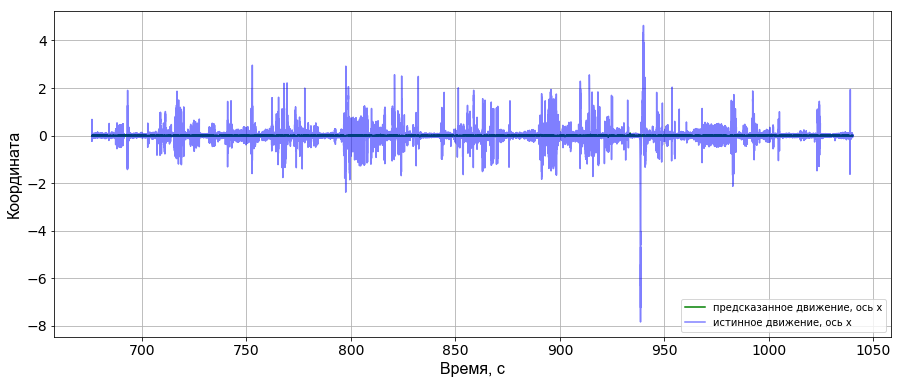

In [65]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, motion[:, 1:], test_size=0.35, shuffle = False)
model = LinearRegression(n_jobs = -1)
model.fit(Xr_train,yr_train)
Y_pred = model.predict(Xr_test)

plt.figure(figsize = (15,6))
plt.plot(time[-(len(Y_pred)):],Y_pred[:, 0], color = 'green',label = 'предсказанное движение, ось х')
plt.plot(time[-(len(Y_pred)):],yr_test[:, 0], color = 'blue', alpha = 0.5, label = 'истинное движение, ось х')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

In [63]:
print(' mae: ', mean_absolute_error(yr_test, Y_pred),'\n mse: ',mean_squared_error(yr_test, Y_pred),'\n r2-score: ',\
      r2_score(yr_test,Y_pred))

 mae:  0.1510574406802435 
 mse:  0.2992854524344048 
 r2-score:  0.00014052882528181598


In [244]:
print(' mae: ', mean_absolute_error(y_test, y_pred),'\n mse: ',mean_squared_error(y_test, y_pred),'\n r2-score: ',\
      r2_score(y_test,y_pred))

 mae:  34.66748979942134 
 mse:  2117.987429457212 
 r2-score:  0.10762342687096271


In [27]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor( criterion='mse', max_depth=20, min_samples_split=2, min_samples_leaf=1,\
                                 min_weight_fraction_leaf=0.0, max_features='auto', \
                                 max_leaf_nodes=None,bootstrap=True, n_jobs=-1, random_state=42, warm_start=False)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [246]:
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

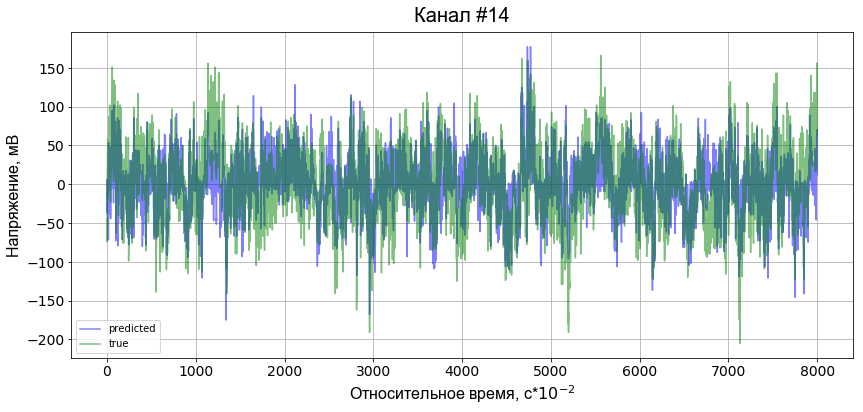

In [247]:
N = 8000
plt.figure(figsize = (14, 6))
plt.plot(range(len(y_pred[:N])),y_pred[:N,1], alpha = 0.5, color = 'blue', label = 'predicted')
plt.plot(range(len(y_pred[:N])),y_test[:N,1], alpha = 0.5, color = 'green', label = 'true')
plt.legend()
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Относительное время, с*$10^{-2}$', **axis_font)
plt.ylabel('Напряжение, мВ', **axis_font)
plt.grid(True)
plt.show()

In [248]:
print(' mae: ', mean_absolute_error(y_test, y_pred),'\n mse: ',mean_squared_error(y_test, y_pred),'\n r2-score: ',\
      r2_score(y_test,y_pred))

 mae:  31.28821087443399 
 mse:  1814.6537884174336 
 r2-score:  0.25603397029731795


####  Эксперимент с расширением признакового пространства парой статистик


In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
m_s = []
d_s = []
min_s = []
max_s = []
for i in range(len(m)):
    m_s.append(ecog_signal[i, 1:].mean())
    d_s.append(ecog_signal[i, 1:].std())
    min_s.append(min(ecog_signal[i, 1:]))   
    max_s.append(max(ecog_signal[i, 1:]))   

In [12]:
X = np.c_[m, d, intens, m_s, d_s, min_s, max_s]

In [13]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


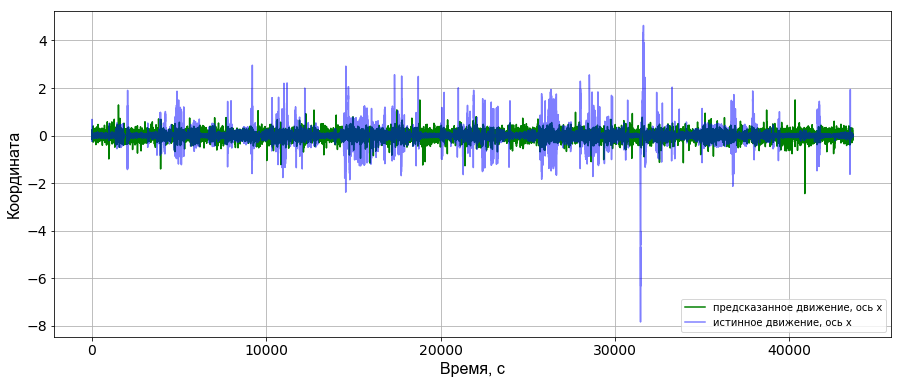

In [70]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, motion[:, 1:], test_size=0.35, shuffle = False)
'''model = LinearRegression(n_jobs = -1)
model.fit(Xr_train,yr_train)
y_pred = model.predict(Xr_train)
'''
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor( criterion='mse', max_depth=50, min_samples_split=2, min_samples_leaf=1,\
                                 min_weight_fraction_leaf=0.0, max_features='auto', \
                                 max_leaf_nodes=None,bootstrap=True, n_jobs=-1, random_state=42, warm_start=False)

model_rf.fit(Xr_train, yr_train)
y_pred = model_rf.predict(Xr_test)
plt.figure(figsize = (15,6))
plt.plot(y_pred[:, 0], color = 'green',label = 'предсказанное движение, ось х')
plt.plot(yr_test[:, 0], color = 'blue', alpha = 0.5, label = 'истинное движение, ось х')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

In [73]:
from sklearn.metrics import r2_score
r2_score(yr_test[:,1],y_pred[:, 1])

-0.14510104246658218

In [74]:
from  sklearn.model_selection import GridSearchCV
sth = GridSearchCV(model_rf, param_grid = [
    {'max_depth': np.arange(1, 101, 10)}], scoring='r2', n_jobs=-1, cv = 5, return_train_score=True)

In [75]:
sth.fit(Xr_train,yr_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_depth': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [76]:
sth.best_params_

{'max_depth': 1}

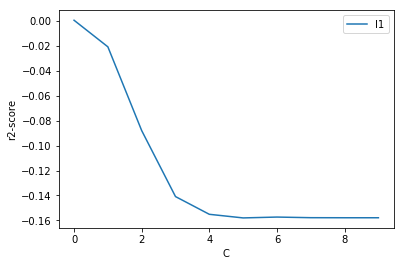

In [77]:
tmp = sth.cv_results_['mean_test_score']

plt.plot(tmp,label="l1")
plt.legend()
plt.xlabel("C")
plt.ylabel("r2-score")
plt.show()